In [1]:
import sys
sys.path.append("../DeepGeSeq/")
print(sys.path)

['/share/home/zhanglab/user/lijiaqi/NvTK_manuscript/4_NvTK_single_cell', '/share/home/zhanglab/user/lijiaqi/tools/cactus-bin-v2.6.12/lib', '/share/home/zhanglab/user/lijiaqi/NvTK_manuscript/4_NvTK_single_cell', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python39.zip', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/lib-dynload', '', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/site-packages', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/share/home/zhanglab/user/lijiaqi/anaconda3/lib/python3.9/site-packages/setuptools/_vendor', '/share/home/zhanglab/user/lijiaqi/.ipython', '../DeepGeSeq/']


In [2]:
import h5py, os, argparse, logging, time

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

import DGS as dgs
from DGS.DL.Trainer import Trainer
from DGS.Model.Publications import DeepSEA
from DGS.DL.Evaluator import calculate_classification_metrics


In [7]:
os.makedirs("./Log", exist_ok=True)
dgs.initialize_logger(time.strftime('./Log/log_nvtk_deepsea.%m%d.%H:%M:%S.txt'), verbosity=1)

# args
parser = argparse.ArgumentParser()
parser.add_argument("data")
parser.add_argument("--gpu-device", dest="device_id", default="0")
args = parser.parse_args(['./data_scbasset_tutorial/Dataset.buen_ad_sc.X.h5', 
                          '--gpu-device', '0'])
logging.info(args)


In [8]:
## change device
os.environ["CUDA_VISIBLE_DEVICES"] = args.device_id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare dataset

1. unpack the h5file datasets
2. generate the DataLoader

In [9]:
# unpack datasets
h5file = h5py.File(args.data, 'r')
anno = h5file["peak"][:].astype(str)
X = h5file["X"][:].swapaxes(1,-1).astype(np.float32)
h5file.close()

X.shape

(103151, 4, 2000)

In [10]:
# unpack anno
n_tasks = anno.shape[0]
anno[:5]

array([['chr1', '9519', '11519', '182', 'True', 'False'],
       ['chr1', '12502', '14502', '41', 'True', 'False'],
       ['chr1', '15249', '17249', '49', 'True', 'False'],
       ['chr1', '95600', '97600', '107', 'True', 'False'],
       ['chr1', '114731', '116731', '21', 'True', 'False']], dtype='<U9')

In [11]:
train_sel = anno[:,4] == 'True'
test_sel = anno[:,5] == 'True'

In [12]:
x_train = X[train_sel][5000:]
x_val = X[train_sel][:5000]
x_test = X[test_sel]

x_train.shape, x_val.shape, x_test.shape

((93792, 4, 2000), (5000, 4, 2000), (4359, 4, 2000))

In [13]:
import anndata
fname = "./data_scbasset_tutorial/buen_ad_sc.h5ad"
ad = anndata.read_h5ad(fname)
ad

AnnData object with n_obs × n_vars = 2034 × 103151
    obs: 'cell_barcode', 'label', 'batch'
    var: 'chr', 'start', 'end', 'n_cells'
    uns: 'label_colors'

In [14]:
Y = ad.to_df().values.T
np.unique(Y)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  95.,  96.,  97., 103., 105.,
       112., 114., 146.], dtype=float32)

In [15]:
Y = np.where(Y >= 1, 1., 0.)
Y = Y.astype(np.float32)
print(Y.shape)

np.unique(Y, return_counts=True)

(103151, 2034)


(array([0., 1.], dtype=float32), array([197088765,  12720369]))

In [16]:
y_train = Y[train_sel][5000:]
y_val = Y[train_sel][:5000]
y_test = Y[test_sel]

In [17]:
# define data loader
batch_size = 1000
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size,
                            shuffle=True, num_workers=0, drop_last=False, pin_memory=True)
validate_loader = DataLoader(list(zip(x_val, y_val)), batch_size=batch_size, 
                            shuffle=False, num_workers=0, drop_last=False, pin_memory=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=batch_size, 
                            shuffle=False, num_workers=0, drop_last=False, pin_memory=True)

## Define DeepSEA model
Initialized DeepSEA architectures in NvTK

In [19]:
model = DeepSEA(sequence_length=2000, n_genomic_features=2034)
model

DeepSEA(
  (conv_net): Sequential(
    (0): Conv1d(4, 320, kernel_size=(8,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(320, 480, kernel_size=(8,), stride=(1,))
    (5): ReLU(inplace=True)
    (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv1d(480, 960, kernel_size=(8,), stride=(1,))
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=110400, out_features=2034, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=2034, out_features=2034, bias=True)
    (3): Sigmoid()
  )
)

In [20]:
optimizer = Adam([
    {'params': model.conv_net.parameters(), 'lr': 1e-6},
    {'params': model.classifier.parameters(), 'lr': 1e-3}])
criterion = nn.BCELoss().to(device)
trainer = Trainer(model, criterion, optimizer, device, patience=5)


## Trained the model 
as an example, we only finetune the DeepSEA model architectures on TFBS sub-dataset for 10 EPOCHs.

In [21]:
# train
trainer.train(train_loader, validate_loader, epochs=200)

Epoch 6: 100%|██████████| 94/94 [00:36<00:00,  2.61it/s, loss=0.1992]


TrainerMetrics(train_losses=[0.22013851033246262, 0.2008448285942382, 0.20017939599904608, 0.19934580776285618, 0.19964639573021137, 0.19975779823800352, 0.19917362405264633], val_losses=[0.2436140298843384, 0.22784987688064576, 0.23724244236946107, 0.23283236026763915, 0.2536538541316986, 0.22859518229961395, 0.22966994643211364], train_metrics=[], val_metrics=[], best_val_loss=0.22784987688064576, best_val_metric=0.0, best_epoch=1)

In [22]:
# if you have enabled tensorboard
# !tensorboard --logdir=runs --bind_all

## Evaluated the model

In [24]:
os.makedirs("Metric", exist_ok=True)

# predict test-set
_, _, test_predictions, test_targets = trainer.validate(test_loader, return_predictions=True)

In [27]:
# metric test-set
metric = calculate_classification_metrics(test_targets.cpu().data.numpy(), test_predictions.cpu().data.numpy())
metric

,auroc,auprc,f1,accuracy
task_0,0.756619,0.045089,0.000000,0.988529
task_1,0.843397,0.026689,0.000000,0.994494
task_2,0.780029,0.042568,0.000000,0.986924
task_3,0.812679,0.059723,0.000000,0.988300
task_4,0.753254,0.042914,0.000000,0.992429
...,...,...,...,...
task_2029,0.654942,0.287538,0.032626,0.863960
task_2030,0.738141,0.032840,0.000000,0.988071
task_2031,0.678246,0.176165,0.000000,0.926359
task_2032,0.733930,0.143608,0.000000,0.953889


In [29]:
# metric test-set
metric = calculate_classification_metrics(test_targets.cpu().data.numpy().T, test_predictions.cpu().data.numpy().T)
metric.index = ["peak_"+str(i) for i in range(metric.shape[0])]
metric

,auroc,auprc,f1,accuracy
peak_0,0.766426,0.111578,0.000000,0.968535
peak_1,0.742934,0.469718,0.124031,0.777778
peak_2,0.720895,0.212748,0.195918,0.903147
peak_3,0.742817,0.031273,0.000000,0.987217
peak_4,0.711647,0.039359,0.000000,0.980334
...,...,...,...,...
peak_4354,0.732515,0.041806,0.000000,0.988692
peak_4355,0.710124,0.103407,0.000000,0.963127
peak_4356,0.720398,0.437161,0.062222,0.792527
peak_4357,0.414468,0.009750,0.000000,0.989184


In [62]:
# show_auc_curve(fpr=fpr, tpr=tpr, roc_auc=roc_auc, save=False, fig_size=(5, 4))

## Benchmark

In [30]:
cellanno = ad.obs.copy()
cellanno.index.name = None
cellanno.head()

,cell_barcode,label,batch
BM1077-CLP-Frozen-160106-13,BM1077-CLP-Frozen-160106-13,CLP,BM1077
BM1077-CLP-Frozen-160106-14,BM1077-CLP-Frozen-160106-14,CLP,BM1077
BM1077-CLP-Frozen-160106-2,BM1077-CLP-Frozen-160106-2,CLP,BM1077
BM1077-CLP-Frozen-160106-21,BM1077-CLP-Frozen-160106-21,CLP,BM1077
BM1077-CLP-Frozen-160106-27,BM1077-CLP-Frozen-160106-27,CLP,BM1077


In [31]:
metric = pd.read_csv("Metric/Metric.perCell.csv", index_col=0)
metric.head()

,auroc,aupr
0,0.785941,0.074764
1,0.843704,0.073117
2,0.764756,0.061296
3,0.827275,0.078910
4,0.758206,0.072712


In [32]:
metric['celltype'] = cellanno['label'].values
metric['batch'] = cellanno['batch'].values
metric.head()

,auroc,aupr,celltype,batch
0,0.785941,0.074764,CLP,BM1077
1,0.843704,0.073117,CLP,BM1077
2,0.764756,0.061296,CLP,BM1077
3,0.827275,0.078910,CLP,BM1077
4,0.758206,0.072712,CLP,BM1077


(0.3, 1.05)

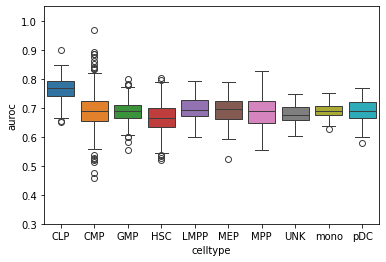

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(metric, x="celltype", y='auroc', hue="celltype")
plt.ylim(0.3,1.05)